In [2]:
import mne
import numpy as np
import os
from matplotlib import pyplot as plt
from mne.preprocessing import ICA
import pandas as pd
from mne.minimum_norm import apply_inverse, make_inverse_operator

# Introduction

Let's learn how to analyze MEG data! We will use the [MNE Python package](https://mne.tools/stable/index.html). I encourage you to read the documentation and explore their website; their tutorials will be very useful on your MEG journey :)


## The data
In this tutorial, you will work with data from an MEG study involving two blocks. Specifically, one block is a repetition primed word-reading task (comp), and the other is a repetition primed picture-naming task (prod). Repetition priming is expected to result in repetition suppression, the neural phenomenon in which the response to a stimulus upon second presentation is reduced compared to the first presentation. Repetition suppression "lights up" regions that are involved in processing the stimulus. With this data, we hope to evaluate if the same neural procedures are being engaged during language comprehension (word-reading) and language production (picture-naming). That means looking at the magnitude, timecourse, and spatial loci of reduction effects.

For this experiment, preprocessing needs to be carried out separately, but identically, on each continuous block of data to allow for comparisons.

The workflow is applicable to studies with one block (or 3+), you just will only perform preprocessing once (or 3+ times).

![trial](Pictures/Trial.jpg "Trial")

## Overview of Preprocessing

The purpose of preprocessing our MEG data is to clean the data and increase the signal to noise ratio. To do so, we will do our best to remove components of the data that were not produced by brain activity. These "artifacts" come from sources like eye blinks, heartbeats, eye movements, head movements, muscle clenches, electronics, and imperfect shielding of the MSR.

We do not expect to completely isolate our signal of interest just by removing artifacts -- that would mean that the only neural activity on any given trial is solely a product of processing the stimulus of interest. Our solution is to average the response to a stimulus across a large number of trials, performing what we call an **evoked object**. When we are working with averaged data, we have a higher SNR because neural activity that is unrelated to the stimulus of interest (ideally) cancels itself out to some extent.

We will use these average responses in two different coordinate spaces: **sensor and source**. Sensor space analyses are done directly on the signals measured at the MEG sensors. Source space analyses, on the other hand, involve reconstructed brain activity on a cortical surface or volumetric grid. Source space analyses require additional preprocessing, but allow us to estimate where exactly in the brain a response is localized to.

Both sensor and source space analyses are useful in understanding our data and evaluating our hypotheses. Even if your hypothesis is most concerned with spatial loci of effects, which the source space is much better for, the sensor space allows your results to be more translatable to the broader EEG literature.

# Custom functions

Specific to the UMD MEG system, it is necessary to manually correct the location of (0-indexed) MEG sensor 56. The .fif file type has an attribute which identifies the locations of every channel, indexed via *raw.info['chs'][idx]['loc']*, where idx is the index of a channel whose location you want to view. It's important that the location of all channels is correct for many parts of the preprocessing pipeline, like interpolating bad channels.

We have the location value that MEG 056 *should* have. The function below will correct the sensor location and should be called for all files recorded using the UMD MEG system.

In [1]:
def fix_56(raw):
    # Fix the location of MEG 056, necessary for all data collected at KIT-UMD MEG Lab
    loc = np.array([
        0.09603, -0.07437, 0.00905, -0.5447052, -0.83848277,
        0.01558496, 0., -0.01858388, -0.9998273, 0.8386276,
        -0.54461113, 0.01012274])
    index = raw.ch_names.index('MEG 056')
    raw.info['chs'][index]['loc'] = loc
    return raw

# Importing Files

Change the ROOT filepath, input_dir filepath, and output_dir file path to correspond to the directories where the experimental data is saved and where you want preprocessed data to save to. Everything else *should* be fine to run without editing, save for the ICA components to remove.

In [3]:
sub = 'R3289'
condition = 'G'

In [7]:
ROOT = f"/Users/audreylaun/"
input_dir = f"{ROOT}Desktop/tutorial_data/"
output_dir = f"{ROOT}Desktop/tutorial_data/output/"

For this experiment, it's necessary to store the conditions for the comprehension and production blocks, these can be obtained based on the overall condition value (A-H)

In [5]:
comp_condition = 'X'
prod_condition = 'X'
if condition in ['A', 'D']:
    comp_condition = 'A1'
    prod_condition = 'B1'
elif condition in ['B','C']:
    comp_condition = 'B1'
    prod_condition = 'A1'
elif condition in ['E','H']:
    comp_condition = 'A2'
    prod_condition = 'B2'
elif condition in ['F', 'G']:
    comp_condition = 'B2'
    prod_condition = 'A2'

We will load continuous experimental files (comp-raw and prod-raw) *and* empty room files (emptyroom) that were recorded with our MEG system. The empty room file can be used for denoising, or noise covariance. In this specific tutorial, we do not use the empty room. Nevertheless, it is still good practice to preprocess the empty room file the exact same way that you preprocess your experimental data, in case it becomes useful down the line.

The experimental files loaded here have already been converted from .sqd (SQUID sensor file) to .fif (Functional Imaging File) using the [kit2fiff terminal GUI](https://mne.tools/stable/generated/commands.html), which you will have to do for your own experiment.

Notice that we loaded the empty room as a sqd file. The conversion is not necessary because we do not need to set the head shape/marker measurement attributes because there are none for these data. Instead, we will assign the info from an experimental fif file so that we can Maxwell filter the empty room file the same way as the experimental blocks.

In [8]:
comp_raw_fname = input_dir + sub + '_comp-raw.fif'
prod_raw_fname = input_dir + sub + '_prod-raw.fif'
empty_room_fname = input_dir + sub + '_emptyroom.sqd'

comp_raw = mne.io.read_raw_fif(comp_raw_fname, preload=True)
prod_raw = mne.io.read_raw_fif(prod_raw_fname, preload=True)
empty_room_raw = mne.io.read_raw_kit(empty_room_fname, preload=True)
empty_room_raw = mne.io.RawArray(empty_room_raw.get_data(), comp_raw.info)

Opening raw data file /Users/audreylaun/Desktop/tutorial_data/R3289_comp-raw.fif...
    Range : 0 ... 717999 =      0.000 ...   717.999 secs
Ready.
Reading 0 ... 717999  =      0.000 ...   717.999 secs...
Opening raw data file /Users/audreylaun/Desktop/tutorial_data/R3289_prod-raw.fif...
    Range : 0 ... 723999 =      0.000 ...   723.999 secs
Ready.
Reading 0 ... 723999  =      0.000 ...   723.999 secs...
Extracting SQD Parameters from /Users/audreylaun/Desktop/tutorial_data/R3289_emptyroom.sqd...
Creating Raw.info structure...
Setting channel info structure...
Creating Info structure...
Reading 0 ... 119999  =      0.000 ...   119.999 secs...
Ready.
Creating RawArray with float64 data, n_channels=193, n_times=120000
    Range : 0 ... 119999 =      0.000 ...   119.999 secs
Ready.


A .fif file stores MEG data and all associated metadata—such as channel information, sensor locations, and digitization points in a structured binary format used throughout MNE.

We can look at the fif file's attributes below:

In [9]:
print(comp_raw.info)

<Info | 13 non-empty values
 bads: []
 ch_names: MEG 001, MEG 002, MEG 003, MEG 004, MEG 005, MEG 006, MEG 007, ...
 chs: 157 Magnetometers, 3 Reference Magnetometers, 32 misc, 1 Stimulus
 custom_ref_applied: False
 description: University of Maryland/Kanazawa Institute of ...
 dev_head_t: MEG device -> head transform
 dig: 2206 items (3 Cardinal, 5 HPI, 2198 Extra)
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 kit_system_id: 54 (University of Maryland, 2019-)
 lowpass: 200.0 Hz
 meas_date: 2025-05-13 20:03:40 UTC
 meas_id: 4 items (dict)
 nchan: 193
 projs: []
 sfreq: 1000.0 Hz
>


Now, we have raw fif files loaded for both experimental blocks.

# Fix the location of sensor 56

We call our custom function is called to fix the location for all files.

In [10]:
comp_raw = fix_56(comp_raw)
prod_raw = fix_56(prod_raw)
empty_room_raw = fix_56(empty_room_raw)

# Excluding bad channels

Before further preprocessing, we need to exclude channels that are "bad". Channels should be included if they are flat (recording no data) or include excessive power surges/artifacts.

MEG 056 and MEG 086 are always bad. 056 shows up inside the head and, even though the position can be corrected, the measurements it takes are not trustworthy. 086 is flat. We will always mark these as bad

In [45]:
bads = ['MEG 056', 'MEG 086']

Other sensors are *sometimes* bad. We will call the [mne.preprocessing.find_bad_channels_maxwell_](https://mne.tools/stable/generated/mne.preprocessing.find_bad_channels_maxwell.html) function to automatically detect these channels

We will look for bad channels in both experimental files, creating a "master list" of bads, which will be excluded from both experimental files and the empty room.

In [12]:
noisy_chs, flat_chs = mne.preprocessing.find_bad_channels_maxwell(
        comp_raw, ignore_ref=True
    )
for i in bads:
    if i not in noisy_chs:
        noisy_chs.append(i)
noisy_chs, flat_chs = mne.preprocessing.find_bad_channels_maxwell(
        prod_raw, ignore_ref=True
    )
for i in bads:
    if i not in noisy_chs:
        noisy_chs.append(i)


comp_raw.info['bads'] = noisy_chs
prod_raw.info['bads'] = noisy_chs
empty_room_raw.info['bads'] = noisy_chs

Applying low-pass filter with 40.0 Hz cutoff frequency ...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)

Scanning for bad channels in 143 intervals (5.0 s) ...
    No bad MEG channels
    Processing 0 gradiometers and 157 magnetometers (of which 157 are actually KIT gradiometers)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -1.7, 4.8, 43.7 mm in the head frame
        Interval   1:    0.000 -    4.999
            Flat ( 1): MEG 086
        Interval   2:    5.000 -    9.999
            Flat ( 1): MEG 086
        Interval   3:   10.000 -   14.999
            Flat ( 1)

# Maxwell Filtering

We will use the [mne.preprocessing.maxwell_filter](https://mne.tools/stable/generated/mne.preprocessing.maxwell_filter.html#mne.preprocessing.maxwell_filter) function to filter the data using mutipole moments. Essentially, this preprocessing step will clean the data by suppressing signals from distant sources.

Because of our specific MEG system, it is important to specifically set some parameters for this function. Specifically, we need to set **ignore_ref** to **True** and **st_only** to **True**. This means that we will only perform temporal projections (tSSS instead of SSS) on the output data because our the KIT system does not allow for cross-talk cancellation and movement compensation.

In [13]:
comp_raw_tsss = mne.preprocessing.maxwell_filter(
        comp_raw,
        st_duration=10,
        ignore_ref=True,
        st_correlation=0.9,
        st_only=True
    )

prod_raw_tsss = mne.preprocessing.maxwell_filter(
    prod_raw,
    st_duration=10,
    ignore_ref=True,
    st_correlation=0.9,
    st_only=True
)

empty_room_raw_tsss = mne.preprocessing.maxwell_filter(
    empty_room_raw,
    st_duration=10,
    ignore_ref=True,
    st_correlation=0.9,
    st_only=True
)

os.makedirs(output_dir, exist_ok=True)
fname = output_dir + '/' + sub + '_emptyroom_preproc-raw.fif'
mne.io.Raw.save(empty_room_raw_tsss, fname, overwrite=True)

Maxwell filtering raw data
    Bad MEG channels being reconstructed: ['MEG 046', 'MEG 056', 'MEG 086']
    Processing 0 gradiometers and 157 magnetometers (of which 157 are actually KIT gradiometers)
    Automatic origin fit: head of radius 91.0 mm
    Using origin -1.7, 4.8, 43.7 mm in the head frame
    Processing data using tSSS with st_duration=10.0
    Using loaded raw data
        Using 80/95 harmonic components for    0.000  (68/80 in, 12/15 out)
    Processing   71 data chunks of (at least) 10.0 s with 0.0 s overlap and boxcar windowing
    The final 8.0 s will be lumped into the final window
        Using 80/95 harmonic components for    0.000  (68/80 in, 12/15 out)
        Projecting  3 intersecting tSSS components for    0.000 -    9.999 s
        Projecting  2 intersecting tSSS components for   10.000 -   19.999 s
        Projecting  2 intersecting tSSS components for   20.000 -   29.999 s
        Projecting  2 intersecting tSSS components for   30.000 -   39.999 s
        

[PosixPath('/Users/audreylaun/Desktop/tutorial_data/output/R3289_emptyroom_preproc-raw.fif')]

# ICA

We will now perform ICA on the data. The purpose of ICA is to remove muscular artifacts from the MEG data. These artifacts are eye blinks, heart beats, and saccades. Therefore, we will not run ICA on our empty room data.

We will fit our ICA model ot a 1Hz high-pass filtered version of the data to eliminate any slow drifts that would decrease the calculated independence of sources.

To carry out ICA, the MNE function [mne.preprocessing.ICA](https://mne.tools/stable/generated/mne.preprocessing.ICA.html) first conducts a principal components analysis (PCA) to whiten the data. The resulting PCA components explain 99% of the variance. Then, it will pass the first 30 components to the ICA algorithm. We will fit the model using the fastica method, which is default.

Below are examples of each type of artifact as seen on the topographic and timecourse plots.
![artifacts](Pictures/Artifacts.jpg "Artifacts")



We will start with the comprehension. ICA is the one part of preprocessing that needs to be done slightly differently for the two blocks, because different component numbers will refer to artifacts.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)

Fitting ICA to data using 154 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 11.0s.
Creating RawArray with float64 data, n_channels=30, n_times=718000
    Range : 0 ... 717999 =      0.000 ...   717.999 secs
Ready.
Using qt as 2D backend.
Using pyopengl with version 3.1.9


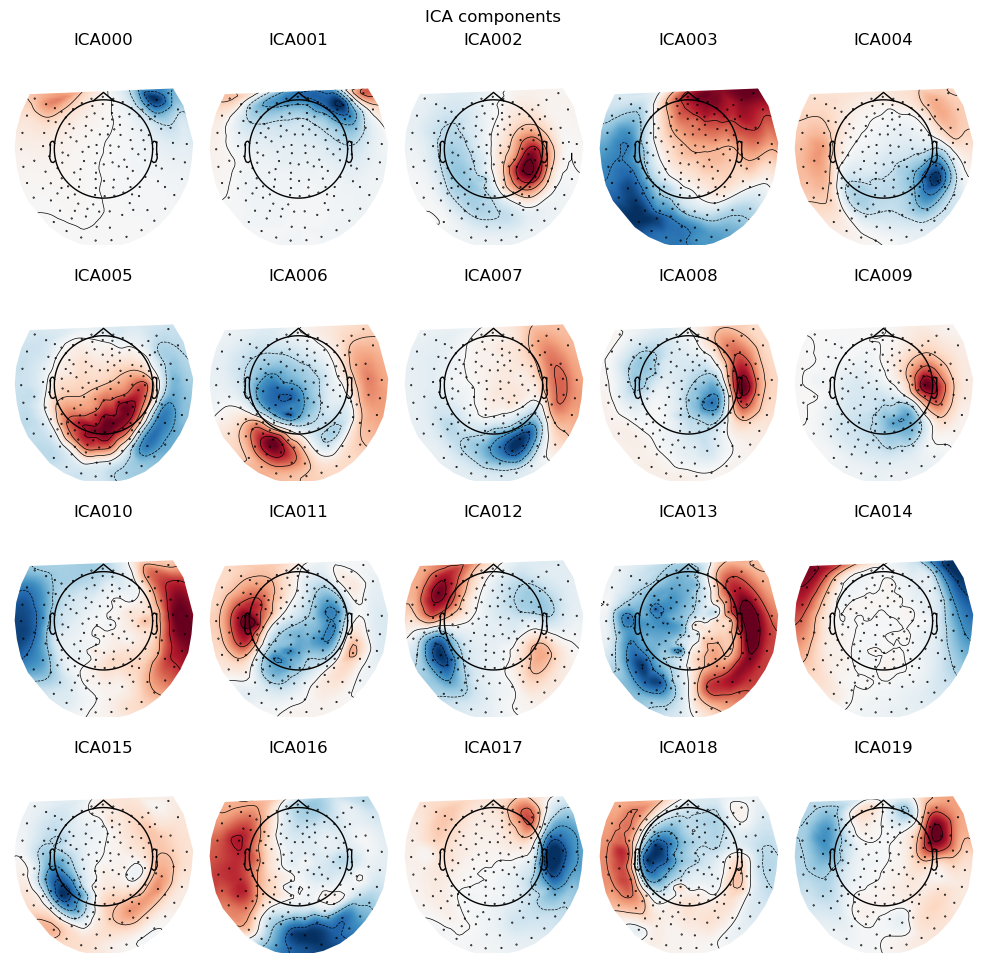

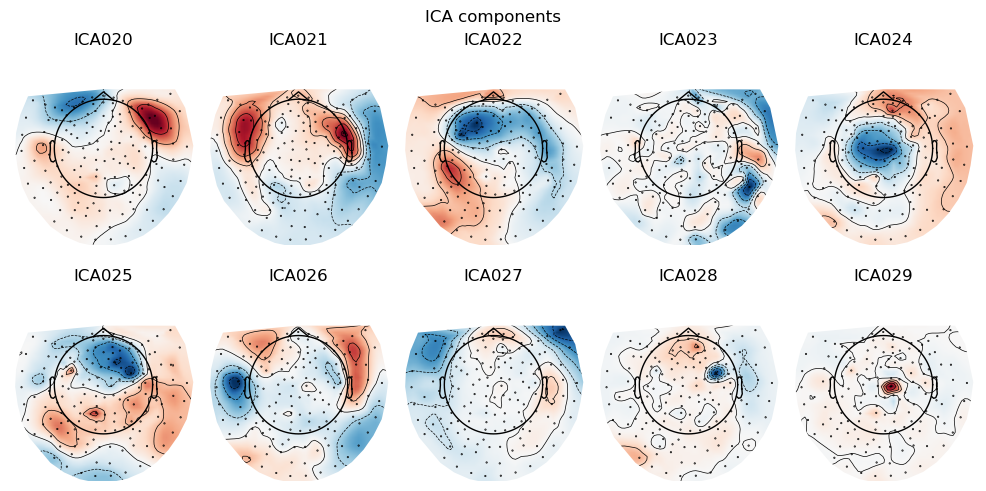

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [14]:
comp_raw_tsss_filt = comp_raw_tsss.copy().filter(l_freq=1.0, h_freq=None)
ica = ICA(n_components=30, max_iter="auto")
ica.fit(comp_raw_tsss_filt)

ica.plot_sources(comp_raw_tsss, show_scrollbars=True)
ica.plot_components()

From the topographic maps and timecourse plots, you will need to manually identify components that contain eye blinks, saccades, or heartbeats. Try to not exclude anything that you can't attribute to one of these muscular artifacts.

Based on the outputs, **enter the components to be excluded below**

In [15]:
ica_excluded = [0,1,3,10,14]

Then, apply the ICA model to the raw data

In [16]:
ica.exclude = ica_excluded
ica.apply(comp_raw_tsss)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 154 PCA components


<Raw | R3289_comp-raw.fif, 193 x 718000 (718.0 s), ~1.03 GiB, data loaded>

We can now [interpolate](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.interpolate_bads) the values for the bad channels, using values from neighboring sensors to infer the activity that *would* have been in that sensor if it were functioning properly

In [17]:
comp_raw_tsss = comp_raw_tsss.interpolate_bads()

Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
    Computing dot products for 154 MEG channels...
    Computing cross products for 154 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 56/154 components to omit less than 0.0001 (9.4e-05)


Now, we can save the "cleaned" continuous file.

In [18]:
fname = output_dir + '/' + sub + '_comp_preproc-raw.fif'
mne.io.Raw.save(comp_raw_tsss, fname, overwrite=True)

Writing /Users/audreylaun/Desktop/tutorial_data/output/R3289_comp_preproc-raw.fif
Closing /Users/audreylaun/Desktop/tutorial_data/output/R3289_comp_preproc-raw.fif
[done]


[PosixPath('/Users/audreylaun/Desktop/tutorial_data/output/R3289_comp_preproc-raw.fif')]

We will do the same for the production block.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 s)

Fitting ICA to data using 154 channels (please be patient, this may take a while)
Selecting by number: 30 components
Fitting ICA took 16.9s.
Creating RawArray with float64 data, n_channels=30, n_times=724000
    Range : 0 ... 723999 =      0.000 ...   723.999 secs
Ready.
Using pyopengl with version 3.1.9


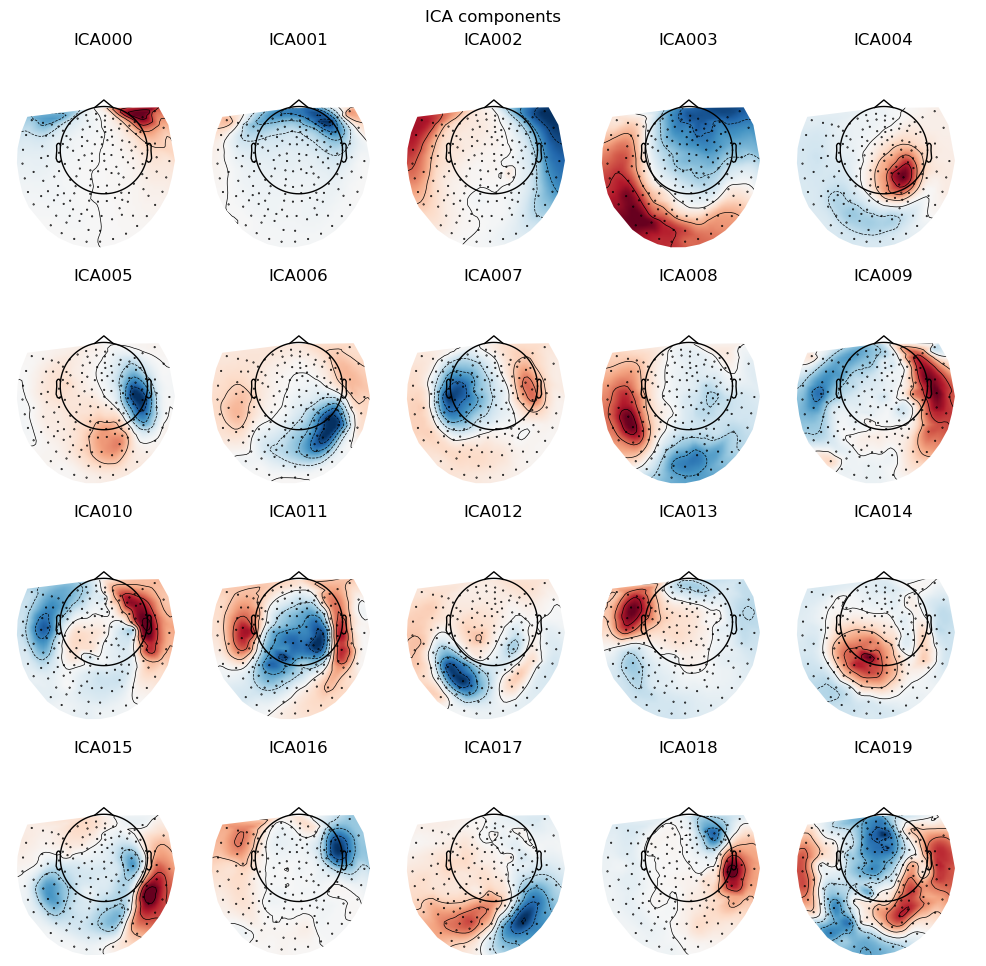

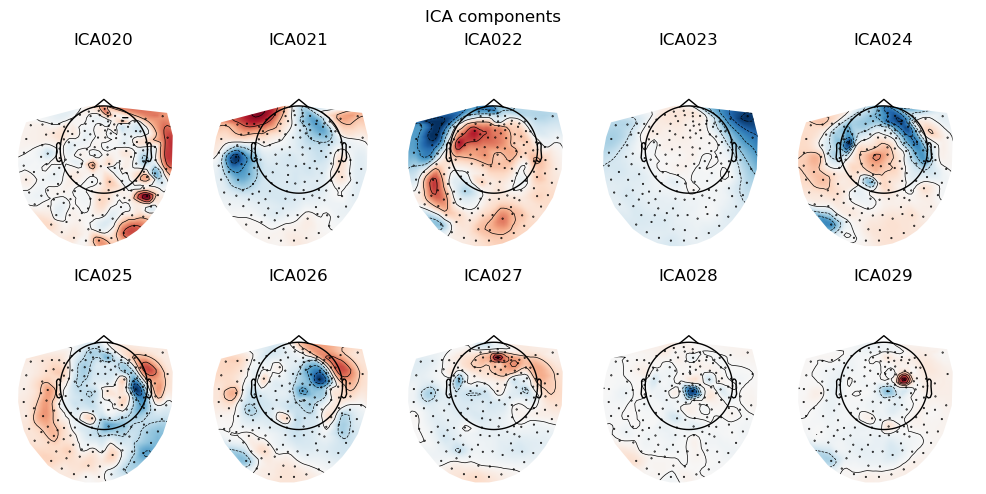

[<MNEFigure size 975x967 with 20 Axes>, <MNEFigure size 975x496 with 10 Axes>]

In [19]:
# High pass filter at 1Hz
prod_raw_tsss_filt = prod_raw_tsss.copy().filter(l_freq=1.0, h_freq=None)

#Fit ICA model with 30 components
ica = ICA(n_components=30, max_iter="auto")
ica.fit(prod_raw_tsss_filt)

#Plot ICA component scalp topographies and timecourses
ica.plot_sources(prod_raw_tsss, show_scrollbars=True)
ica.plot_components()

**Enter the components to exclude**

In [20]:
ica_excluded = [0,1,2,3,9]

In [21]:
ica.exclude = ica_excluded
ica.apply(prod_raw_tsss)

Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 5 ICA components
    Projecting back using 154 PCA components


<Raw | R3289_prod-raw.fif, 193 x 724000 (724.0 s), ~1.04 GiB, data loaded>

In [22]:
prod_raw_tsss = prod_raw_tsss.interpolate_bads()

Setting channel interpolation method to {'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
    Computing dot products for 154 MEG channels...
    Computing cross products for 154 → 3 MEG channels...
    Preparing the mapping matrix...
    Truncating at 55/154 components to omit less than 0.0001 (9.6e-05)


In [23]:
fname = output_dir + '/' + sub + '_prod_preproc-raw.fif'
mne.io.Raw.save(prod_raw_tsss, fname, overwrite=True)

Writing /Users/audreylaun/Desktop/tutorial_data/output/R3289_prod_preproc-raw.fif
Closing /Users/audreylaun/Desktop/tutorial_data/output/R3289_prod_preproc-raw.fif
[done]


[PosixPath('/Users/audreylaun/Desktop/tutorial_data/output/R3289_prod_preproc-raw.fif')]

The continuous data should now look much "cleaner" that it did originally. Let's take a look at the raw and preprocessed files.

In [24]:
comp_raw.plot()

Using pyopengl with version 3.1.9


In [25]:
comp_raw_tsss.plot()

Using pyopengl with version 3.1.9


In [26]:
del comp_raw, prod_raw

# Create Epoch objects for each block

We will now find events that are indicated by trigger channels. We will use separate dictionaries for comprehension and production.

The keys in the event dictionary are the names that you would like to refer to the events as, and the values are the trigger channel number. The trigger channel values are set by the researcher in the experimental script.

It is best practice to include a text file that keeps track of these values. The text files for this experiment are within the parent folder, and the values are as follows:

**Comprehension**\
*Practice*\
137 - Audio onset\
138 - audio offset\
139 - Word \
? Word identical to prime? \
140 - yes comprehension question \
141 - no comprehension question

*Experiment*\
130 - Word Identical to prime (50x)\
132 - Word unrelated to prime (50x)\
136 - Picture unrelated in both lists (50x)\
134 — Audio onset (150x)\
135 — Audio offset (150x)

Buttons\
142 - LEFT\
143 - RIGHT

Questions:\
Yes - 146\
No - 147

**Production**\
*Practice* \
137 - Audio onset \
138 - audio offset\
139 - picture identical to prime \
140 - picture unrelated to prime

Experiment \
130 - Picture Identical to prime (50x)\
132 - Word unrelated to prime (50x)\
136 - Picture unrelated in both lists (50x) \
131 - Production trigger (fires after 130/132) \
134 — Audio onset (150x)\
135 — Audio offset (150x)

Buttons\
142 - LEFT \
143 - RIGHT

We will now define our events dictionary for the comprehension condition. We are only going to be analyzing the target onsets, so our dictionary will only include those event codes.

In the production block, the data are epoched based on the onset of the target image. In the comprehension block, the data are epoched based on the onset of the target word. In other words, when looking at evoked responses, t=0 represents the onset of the image/word.

We will keep the ignore condition (words that were never targets in any counterbalancing, or, fillers) for reasons that will be clear later.

In [47]:
event_dict = {
    "comprehension identical": 162,
    "comprehension unrelated": 164,
    "ignore": 168
}

You may notice that the keys in this dictionary do not match the values from the text file. This is because the value that you input into your script the "binary" trigger value, while the values contained in the .sqd file is the "MEG160" trigger value. Below is the conversion table between binary and MEG160 (hint, just add 32)

![conversions](Pictures/trigger_conversions.png "Trigger Conversions")

We will now use our event dictionary to "label" trials of interest and then save the data as an [epoch object](https://mne.tools/stable/generated/mne.Epochs.html).


In [48]:
# Comprehension
events = mne.find_events(comp_raw_tsss, stim_channel="STI 014") #Always use STI 014

epochs_comp = mne.Epochs(comp_raw_tsss, events, tmin=-0.3, tmax=0.6, event_id=event_dict, preload=True)

Finding events on: STI 014
450 events found on stim channel STI 014
Event IDs: [162 164 166 167 168]
Not setting metadata
150 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 150 events and 901 original time points ...
0 bad epochs dropped


We also don't want any trials where the maximum peak amplitudes exceed a threshold, which would suggest that a movement artifact, power surge, or some other impurity pervaded in the data through our preprocessing, so we will also exclude epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas.

In [49]:
reject_criteria = dict(mag=3000e-15)
epochs_comp.drop_bad(reject=reject_criteria)

0 bad epochs dropped


<Epochs | 150 events (all good), -0.3 – 0.6 s (baseline -0.3 – 0 s), ~199.9 MiB, data loaded,
 'comprehension identical': 50
 'comprehension unrelated': 50
 'ignore': 50>

We will now save our comprehension epoch object

In [50]:
fname = output_dir + '/' + sub + '_comp-epo.fif'
epochs_comp.save(fname, overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


[PosixPath('/Users/audreylaun/Desktop/tutorial_data/output/R3289_comp-epo.fif')]

We will do the same thing with the production block.

In [51]:
events = mne.find_events(prod_raw_tsss, stim_channel="STI 014")

event_dict = {
    "production identical": 162,
    "production unrelated": 164,
    "ignore": 168
}
epochs_prod = mne.Epochs(prod_raw_tsss, events, tmin=-0.3, tmax=0.6, event_id=event_dict, preload=True)

Finding events on: STI 014
600 events found on stim channel STI 014
Event IDs: [162 163 164 166 167 168]
Not setting metadata
150 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 150 events and 901 original time points ...
0 bad epochs dropped


Instead of saving this epoch object immediately, we will **exclude trials that contain bad productions** (where the participant did not name the object correctly).

The production data are stored in the .xlsx file "Productions_A2" in the tutorial folder. As a refresher, A2 is the production condition in the "G" counterbalancing for the experiment.

In this excel sheet, we have information about the intended word, the trigger code, and what the participant produced. With this informaiton, we know if the participant was correct, and if the word had been repetition primed or not.

In [52]:
excel_fname = f"{ROOT}Tutorial/{sub}/Productions_{prod_condition}.xlsx"
df = pd.read_excel(excel_fname)
column_name = sub + ' Accuracy'
bad_productions = df.index[df[column_name] == False].tolist()

This is the part where it matters that we kept the "ignore" condition. The way that we will exclude the bad productions is by using the index of that trial from the excel sheet. The excel sheet contains all words, those that were repetition primed, unrelated primed, and filler words (150 words). If we did not keep the "ignore" condition in our events dictionary, then we would only have 100 items in our epochs object and we would not be able to exclude trials using the indeces from the excel sheet.

Let's look at our epochs object containing **all** productions

In [53]:
print(epochs_prod)
len(epochs_prod)

<Epochs | 150 events (all good), -0.3 – 0.6 s (baseline -0.3 – 0 s), ~199.9 MiB, data loaded,
 'production identical': 50
 'production unrelated': 50
 'ignore': 50>


150

Now, let's drop the bad productions

In [54]:
epochs_prod.drop(bad_productions)

Dropped 30 epochs: 1, 3, 5, 6, 32, 51, 54, 62, 70, 79, 82, 84, 85, 102, 105, 109, 111, 112, 119, 120, 122, 123, 128, 131, 132, 133, 134, 138, 142, 146


<Epochs | 120 events (all good), -0.3 – 0.6 s (baseline -0.3 – 0 s), ~160.1 MiB, data loaded,
 'production identical': 50
 'production unrelated': 35
 'ignore': 35>

Let's look at our epoch object again.

In [55]:
print(epochs_prod)
len(epochs_prod)

<Epochs | 120 events (all good), -0.3 – 0.6 s (baseline -0.3 – 0 s), ~160.1 MiB, data loaded,
 'production identical': 50
 'production unrelated': 35
 'ignore': 35>


120

We can now see that this particular participant had 30 incorrect productions total. 15 of those bad productions were for filler words and the other 15 were for unrelated primed words. All 50 identically primed words were produced correctly.

We will again reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas. It's important to do this step **after** excluding the bad productions to ensure that the indexing works properly.

In [56]:
reject_criteria = dict(mag=3000e-15)
epochs_prod.drop_bad(reject=reject_criteria)

    Rejecting  epoch based on MAG : ['MEG 022', 'MEG 023', 'MEG 027', 'MEG 028', 'MEG 058', 'MEG 060', 'MEG 061', 'MEG 064', 'MEG 066', 'MEG 067', 'MEG 098', 'MEG 100']
    Rejecting  epoch based on MAG : ['MEG 022', 'MEG 023', 'MEG 024', 'MEG 025', 'MEG 027', 'MEG 058', 'MEG 060', 'MEG 061', 'MEG 063', 'MEG 064', 'MEG 066', 'MEG 067', 'MEG 098', 'MEG 100']
2 bad epochs dropped


<Epochs | 118 events (all good), -0.3 – 0.6 s (baseline -0.3 – 0 s), ~157.5 MiB, data loaded,
 'production identical': 50
 'production unrelated': 35
 'ignore': 33>

We will now save the production epochs.


In [38]:
fname = output_dir + '/' + sub + '_prod-epo.fif'
epochs_prod.save(fname, overwrite=True)

[PosixPath('/Users/audreylaun/Desktop/tutorial_data/output/R3289_prod-epo.fif')]

# Equalizing epoch counts

We don't want to have uneven counts for each condition (production identical, production unrelated, comprehension identical, comprehension unrelated) when we are doing data analysis, because higher power for some conditions will bias the source estimates.

 We will equalize epoch counts by creating separate objects for each condition and then randomly excluding trials from objects that have a larger epoch count than the minimum, until they are all the same. In this subject, the lowest epoch count was in the production unrelated condition, so after this function is called, the other three conditions will have the same number of epochs as that condition.

In [57]:
ident_prod = epochs_prod['production identical'].pick('mag')
unrel_prod = epochs_prod['production unrelated'].pick('mag')
ident_comp = epochs_comp['comprehension identical'].pick('mag')
unrel_comp = epochs_comp['comprehension unrelated'].pick('mag')
mne.epochs.equalize_epoch_counts([ident_prod, ident_comp, unrel_prod, unrel_comp], method="random")

Dropped 15 epochs: 4, 6, 9, 12, 13, 14, 15, 20, 26, 28, 31, 32, 42, 43, 48
Dropped 15 epochs: 4, 9, 11, 12, 18, 19, 22, 28, 29, 31, 32, 36, 37, 44, 48
Dropped 0 epochs: 
Dropped 15 epochs: 0, 3, 5, 7, 9, 14, 17, 19, 22, 28, 34, 44, 47, 48, 49


# Create evoked objects for each condition

Now that the epoch counts are equal, we can make evoked objects for each condition, which contain the average response for each condition. We low pass filter the data at 40 Hz because any frequency higher than that is not relevant to the study.

In [58]:
ident_prod = ident_prod.average().filter(l_freq=None, h_freq=40)
unrel_prod = unrel_prod.average().filter(l_freq=None, h_freq=40)
ident_comp = ident_comp.average().filter(l_freq=None, h_freq=40)
unrel_comp = unrel_comp.average().filter(l_freq=None, h_freq=40)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin)

# Plotting your evoked data

We can take a look at our evoked data by plotting the timecourse and topography of different conditions.

In [59]:
evokeds_dict = {
    "Prod Ident": ident_prod,
    "Prod Unrel": unrel_prod,
    "Comp Ident": ident_comp,
    "Comp Unrel": unrel_comp,
}

## All sensors timecourse

combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


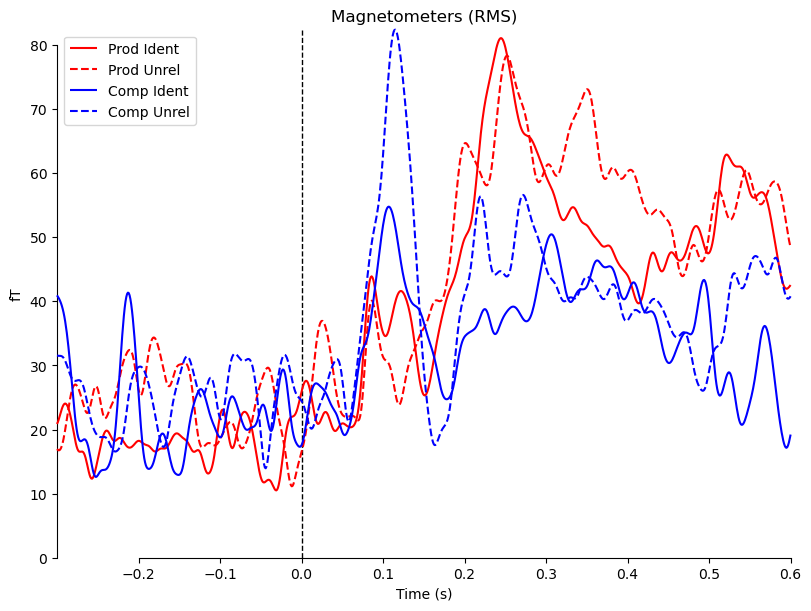

[<Figure size 800x600 with 1 Axes>]

In [60]:
#Timecourse over all sensors
mne.viz.plot_compare_evokeds(evokeds_dict, picks='mag', colors=['red', 'red', 'blue', 'blue'], linestyles=['-', '--', '-', '--'])

## Subset of sensors timecourse

In [61]:
# Get subsets of sensors
# left posterior
left_post_numbers = [4, 5, 6, 7, 8, 9, 34, 36, 37, 38, 40, 47, 48, 49, 50, 75, 76, 77, 79, 88, 127, 129,
                     137, 89, 92, 94, 12, 10, 11, 35, 46, 51, 72, 73, 74, 78, 91, 125, 126, 138, 140, 141, 128, 41]
left_post = []
for i in left_post_numbers:
    title = ""
    if i < 10:
        title = 'MEG 00' + str(i)
    elif 10 <= i < 100:
        title = 'MEG 0' + str(i)
    else:
        title = 'MEG ' + str(i)
    left_post.append(title)

#left anterior
left_ant_numbers = [1, 2, 3, 39, 42, 43, 44, 80, 81, 86, 83, 84, 85, 108, 130, 131, 132, 133, 134, 135,
                    136, 151, 65, 59, 152, 53, 68, 143, 105, 106, 107, 109, 45, 111]
left_ant = []
for i in left_ant_numbers:
    title = ""
    if i < 10:
        title = 'MEG 00' + str(i)
    elif 10 <= i < 100:
        title = 'MEG 0' + str(i)
    else:
        title = 'MEG ' + str(i)
    left_ant.append(title)
print(left_ant)

#right posterior
right_post_numbers = [14, 15, 16, 17, 18, 19, 27, 28, 30, 54, 56, 57, 66, 69, 70, 97, 119, 121, 122,
                      90, 87, 71, 52, 82, 58, 67, 95, 26, 145, 13, 29, 31, 32, 33, 120, 123, 124, 142]
right_post = []
for i in right_post_numbers:
    title = ""
    if i < 10:
        title = 'MEG 00' + str(i)
    elif 10 <= i < 100:
        title = 'MEG 0' + str(i)
    else:
        title = 'MEG ' + str(i)
    right_post.append(title)

#right anterior
right_ant_numbers = [20, 21, 22, 23, 24, 60, 61, 63, 99, 100, 114, 115, 116, 117, 118, 147,
                     148, 155, 96, 25, 62, 64, 98, 101, 102, 103, 104, 112, 113, 119, 93]
right_ant = []
for i in right_ant_numbers:
    title = ""
    if i < 10:
        title = 'MEG 00' + str(i)
    elif 10 <= i < 100:
        title = 'MEG 0' + str(i)
    else:
        title = 'MEG ' + str(i)
    right_ant.append(title)

['MEG 001', 'MEG 002', 'MEG 003', 'MEG 039', 'MEG 042', 'MEG 043', 'MEG 044', 'MEG 080', 'MEG 081', 'MEG 086', 'MEG 083', 'MEG 084', 'MEG 085', 'MEG 108', 'MEG 130', 'MEG 131', 'MEG 132', 'MEG 133', 'MEG 134', 'MEG 135', 'MEG 136', 'MEG 151', 'MEG 065', 'MEG 059', 'MEG 152', 'MEG 053', 'MEG 068', 'MEG 143', 'MEG 105', 'MEG 106', 'MEG 107', 'MEG 109', 'MEG 045', 'MEG 111']


More than 6 channels, truncating title ...
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
More than 6 channels, truncating title ...
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
More than 6 channels, truncating title ...
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
More than 6 channels, truncating title ...
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


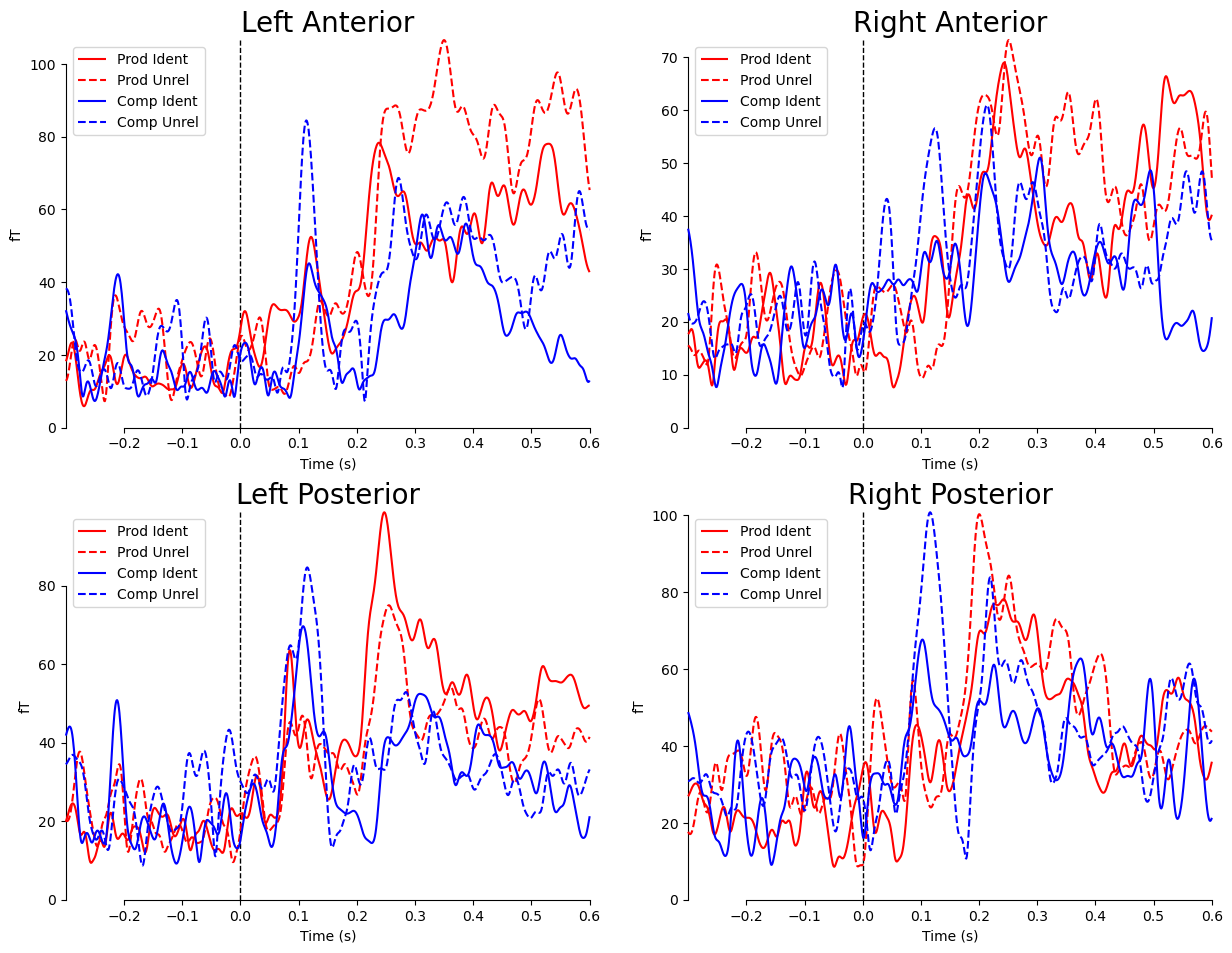

In [64]:
# Plot subsets of sensors
fig, axes = plt.subplots(2, 2, figsize=(13, 10))
fig.tight_layout(pad=4.0)

# Top-left
mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=left_post,
    axes=axes[1, 0],
    colors=['red', 'red','blue', 'blue'], linestyles=['-', '--', '-', '--'],
    show=False,
    # ylim=ylim
)
axes[1, 0].set_title("Left Posterior",size=20)

# Top-right
mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=left_ant,
    axes=axes[0, 0],
    colors=['red', 'red','blue', 'blue'], linestyles=['-', '--', '-', '--'],
    show=False,
    # ylim=ylim
)
axes[0, 0].set_title("Left Anterior",size=20)

# Bottom-left
mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=right_post,
    axes=axes[1, 1],
    colors=['red', 'red','blue', 'blue'], linestyles=['-', '--', '-', '--'],
    show=False,
    # ylim=ylim
)
axes[1, 1].set_title("Right Posterior", size=20)

# Bottom-right
mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=right_ant,
    axes=axes[0, 1],
    colors=['red', 'red','blue', 'blue'], linestyles=['-', '--', '-', '--'],
    show=False,
    # ylim=ylim
)
axes[0, 1].set_title("Right Anterior",size=20)

plt.show()

## Topographic difference plots

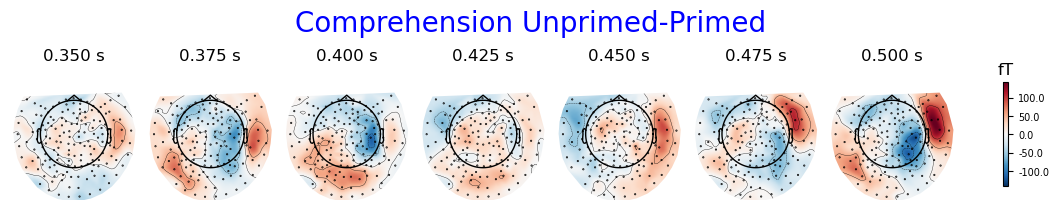

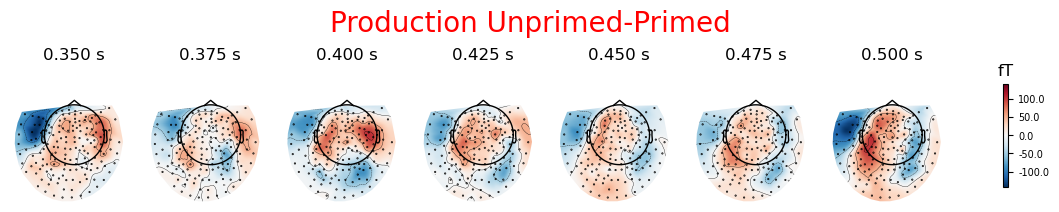

In [66]:
# Difference between unrelated and identical primed conditions for each task
comp_dif = mne.combine_evoked([unrel_comp, ident_comp], weights = [1, -1])
prod_dif = mne.combine_evoked([unrel_prod, ident_prod], weights = [1,-1])

times = np.arange(0.35, 0.5, 0.025)
fig = comp_dif.plot_topomap(times, ch_type="mag", show=False)
plt.suptitle('Comprehension Unprimed-Primed', fontsize=20, color='blue')
plt.show()

times = np.arange(0.35, 0.5, 0.025)
fig = prod_dif.plot_topomap(times, ch_type="mag", show=False)
plt.suptitle('Production Unprimed-Primed', fontsize=20, color='red')
plt.show()

# Obtain STCs (Source Localization!)

Inferring source space activity from  sensor data requires that you have **FreeSurfer** installed, and that you carried out coregistration. Coregistration will produce an anatomical model of the subject's brain based on the digitization as well as yielding a transformation matrix.

To install FreeSurfer, follow the instructions on [this page](https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall).

In this tutorial, coregistration has been done for you. All the results can be found in the Tutorial/freesurfer/R3289 folder. You can follow the instructions in [this document](https://docs.google.com/document/d/16D3C3NQU8hzEc976RHI2Z3RJRwI9mlbs-yQkQ6N0To8/edit?usp=sharing) to do it yourself.

In [67]:
subjects_dir = f"{ROOT}Tutorial/freesurfer/"
directory = f"{ROOT}Tutorial/{sub}/"

We will set some generic parameters for source localization. More information can be found here.

In [68]:
conductivity = (0.3,) # single layer conductivity
baseline_start = -300 #in milliseconds
baseline_end = 0
baseline = (None,0)
snr = 3.0
method = "dSPM"

Now, we will create the anatomical model of our subject. BEM model documentation can be found [here](https://mne.tools/stable/generated/mne.make_bem_model.html), and source space documentation can be found [here](https://mne.tools/stable/generated/mne.setup_source_space.html).

In [69]:
subject = sub
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
inner skull CM is  -0.51 -19.22   5.71 mm
Surfaces passed the basic topology checks.
Complete.

Homogeneous model surface loaded.
Computing the linear collocation solution...
    Matrix coefficients...
        inner skull (2562) -> inner skull (2562) ...
    Inverting the coefficient matrix...
Solution ready.
BEM geometry computations complete.
Setting up the source space with the following parameters:

SUBJECTS_DIR = /Users/audreylaun/Tutorial/freesurfer
Subject      = R3289
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /Users/audreylaun/Tutorial/freesurfer/R3289/surf/lh.white...
Mapping lh R3289 -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /Users/audreylaun/Tutorial/freesurfer/R3289/surf/lh.sphere...
Setting up the triangulation for the decimated surface..

We will now compute the noise covariance using the baseline interval, which spans from the beginning of the evoked timescale (in this case, -300ms), to the image/word onset (0ms).

It is common practice to use the [baseline interval for noise covariance](https://mne.tools/stable/auto_tutorials/forward/90_compute_covariance.html) in evoked experiments, though one could also use the empty room file.

The MNE function does not automatically calculate the noise covariance rank accurately, in my experience. This could be related to the fact that the automatic rank computation does not do a good job taking IC removal during ICA into account. [Here](https://github.com/mne-tools/mne-python/issues/7727) and [here](https://mne.discourse.group/t/specify-noise-covariance-rank-in-mne-python/888/5) are threads that discusses the issue.

My approach is to set the rank manually. Basically, you want to find a numerical value that sets the red dotted line right at the edge of the "shelf" of the curve of noise plotted over eigenvalues.
**Below, change X in {'mag': X} to a value that sets the vertical dotted line at the correct position on the curve.**

*Let me know if you find a better, automatic way to do this step.*

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 149
Estimating covariance using SHRUNK
Done.
Number of samples used : 45150
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.4e-14 (2.2e-16 eps * 157 dim * 0.69  max singular value)
    Estimated rank (mag): 149
    MAG: rank 149 computed from 157 data channels with 0 projectors


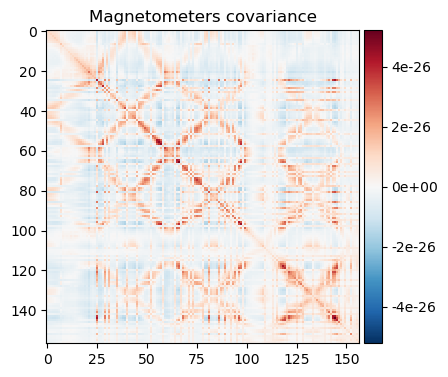

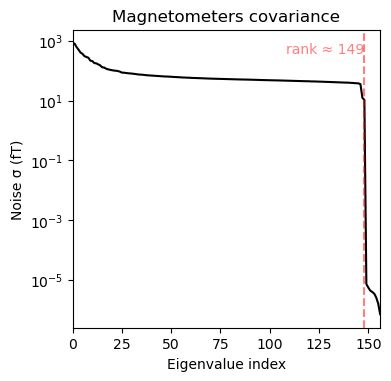

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [70]:
rank = {'mag': 149}
noise_cov_comp = mne.compute_covariance(epochs_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk"], verbose=True)
mne.viz.plot_cov(noise_cov_comp, epochs_comp.info)

Once the rank value looks good, you can compute the forward solution.

In [72]:
trans = input_dir + sub + '-trans.fif'
fname = output_dir + '/' + sub + '_comp_preproc-raw.fif'

# Compute forward solution
fwd_comp = mne.make_forward_solution(
    fname,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3289', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Desktop/tutorial_data/R3289-trans.fif
Measurement data      : R3289_comp_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999864 0.015833 -0.004661      -2.71 mm
    -0.015451 0.997210 0.073029      24.02 mm
    0.005804 -0.072947 0.997319      36.26 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.998169 -0.045272 -0.040123      -5.29 mm
    0.054615 0.959624 0.275933      -3.68 mm
    0.026011 -0.277619 0.960339      47.79 mm
    

Then, you can compute the inverse solution

In [73]:
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_comp = make_inverse_operator(ident_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)
inverse_unrel_comp = make_inverse_operator(unrel_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 157 channels.
    157 out of 157 channels remain after picking
Selected 157 channels
Creating the depth weighting matrix...
    157 magnetometer or axial gradiometer channels
    limit = 8082/8196 = 10.143655
    scale = 9.42045e-12 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 2.4e-14 (2.2e-16 eps * 157 dim * 0.69  max singular value)
    Estimated rank (mag): 149
    MAG: rank 149 computed from 157 data channels with 0 projectors
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    

Then, you can imply the inverse operator to obtain and save your source time courses.

In [74]:
# Calculate STCs using evoked data, inverse operators from above
stc_ident_comp = apply_inverse(ident_comp, inverse_ident_comp, lambda2, method=method, pick_ori="normal")
stc_unrel_comp = apply_inverse(unrel_comp, inverse_unrel_comp, lambda2, method=method, pick_ori="normal")

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 35
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 149 (8 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "comprehension identical"...
    Picked 157 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.2% variance
    dSPM...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 35
    Created the regularized inverter
    The projection vectors do not apply to these channels.
    Created the whitener using a noise covariance matrix with rank 149 (8 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "compreh

A good inverse solution will explain a large amount of the variance in the original data. If your solution explains <65% of the variance, you should try to find a better value for rank, or try to identify if anything could be contributing to a low SNR.

If the inverse solution looks good, you can save your files.

In [75]:
fname_ident_comp = output_dir + sub + '_ident_comp'
stc_ident_comp.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = output_dir + sub + '_unrel_comp'
stc_unrel_comp.save(fname_unrel_comp, ftype='stc', overwrite=True)

Writing STC to disk...
[done]
Writing STC to disk...
[done]


Do the exact same for production.

    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 148
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 35518
log-likelihood on unseen data (descending order):
   shrunk: -828.052
   empirical: -828.053
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.9e-14 (2.2e-16 eps * 157 dim * 0.55  max singular value)
    Estimated rank (mag): 148
    MAG: rank 148 computed from 157 data channels with 0 projectors


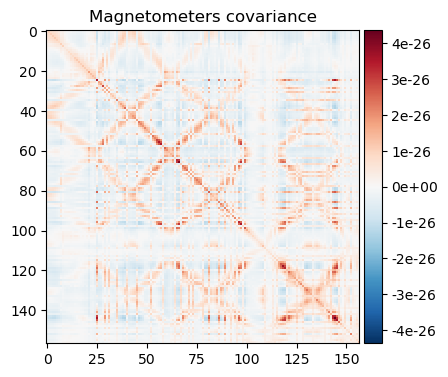

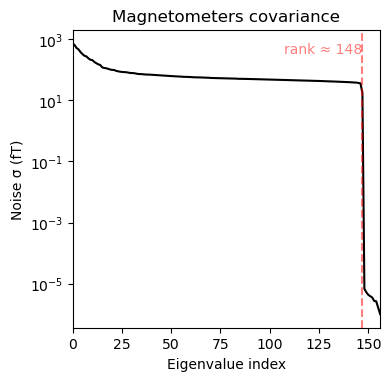

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [76]:
rank = {'mag': 148}
noise_cov_prod = mne.compute_covariance(epochs_prod, tmin=baseline_start, tmax=baseline_end, method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_prod, epochs_prod.info)

In [77]:
fname = output_dir + '/' + sub + '_prod_preproc-raw.fif'
trans = input_dir + sub + '-trans.fif'

# Compute forward solution
fwd_prod = mne.make_forward_solution(
    fname,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_prod = make_inverse_operator(ident_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)
inverse_unrel_prod = make_inverse_operator(unrel_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_ident_prod = apply_inverse(ident_prod, inverse_ident_prod, lambda2, method=method, pick_ori="normal")
stc_unrel_prod = apply_inverse(unrel_prod, inverse_unrel_prod, lambda2, method=method, pick_ori="normal")

fname_ident_comp = directory + sub + '_ident_prod'
stc_ident_prod.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = directory + sub + '_unrel_prod'
stc_unrel_prod.save(fname_unrel_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3289', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Desktop/tutorial_data/R3289-trans.fif
Measurement data      : R3289_prod_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999864 0.015833 -0.004661      -2.71 mm
    -0.015451 0.997210 0.073029      24.02 mm
    0.005804 -0.072947 0.997319      36.26 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.996113 0.062269 -0.062302     -25.84 mm
    -0.048836 0.979043 0.197712     -26.83 mm
    0.073307 -0.193901 0.978278      39.26 mm
    

# Plot STCs

## Individual Conditions

In [80]:
brain = stc_ident_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Repetition Primed')

Using control points [3.11053294 3.59609241 6.87127789]


In [81]:
brain = stc_unrel_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Unrelated Primed')

Using control points [3.72406308 4.35086997 7.66485603]


In [82]:
brain = stc_ident_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Comprehension Repetition Primed')

In [ ]:
brain = stc_unrel_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Comprehension Unrelated Primed')

## Differences between conditions

In [83]:
stc_dif_prod = stc_unrel_prod - stc_ident_prod
stc_dif_comp = stc_unrel_comp - stc_ident_comp

In [84]:
brain = stc_dif_prod.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Production Difference')

Using control points [3.06737358 3.54370875 7.31824419]
Using control points [4.30533926 4.60491916 5.99566505]


In [85]:
brain = stc_dif_comp.plot(
    subjects_dir=subjects_dir,
    hemi='lh',
    smoothing_steps=7,
    initial_time=0.4,
    background='white',
    show_traces=False,
    title='Comprehension Difference')

Using control points [2.16832877 2.39450908 3.94325139]
Using control points [1.88167914 1.99680821 2.58948935]
Using control points [1.88167914 1.99680821 2.58948935]
